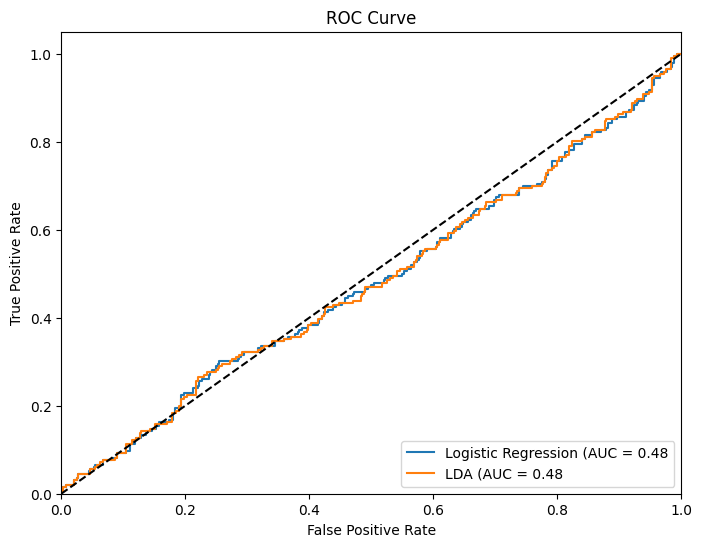


Logistic Regression:
Accuracy: 0.6733
Confusion Matrix:
[[404   0]
 [196   0]]
ROC AUC: 0.4815

LDA:
Accuracy: 0.6733
Confusion Matrix:
[[404   0]
 [196   0]]
ROC AUC: 0.4817

Summary: The best model is LDA with ROC AUC of 0.4817.
Why? The LDA model has the highest ROC AUC, indicating better ability to distinguish between burnout and non-burnout cases across various thresholds.


In [5]:
# Install required packages
!pip install pandas numpy scikit-learn matplotlib -q

# Import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('/content/mental_health_workplace_survey.csv')

# Prepare target variable
df['BurnoutLevel'] = df['BurnoutLevel'].apply(lambda x: 1 if x > 0 else 0)
if len(df['BurnoutLevel'].unique()) < 2:
    print("Warning: BurnoutLevel has only one class. Trying BurnoutRisk as fallback...")
    if 'BurnoutRisk' in df.columns:
        df['BurnoutLevel'] = df['BurnoutRisk'].apply(lambda x: 1 if x > 0 else 0)
    else:
        raise ValueError("Error: Dataset lacks multiple classes for classification.")

# Encode categorical features
categorical_cols = ['Gender', 'Country', 'JobRole', 'Department', 'RemoteWork', 'HasMentalHealthSupport', 'HasTherapyAccess', 'SalaryRange']
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_cats = encoder.fit_transform(df[categorical_cols])
encoded_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_cols))

# Combine encoded data with original dataframe
df = df.drop(categorical_cols, axis=1)
df = pd.concat([df.reset_index(drop=True), encoded_df], axis=1)

# Normalize numerical features
numerical_cols = ['Age', 'YearsAtCompany', 'WorkHoursPerWeek', 'JobSatisfaction', 'StressLevel',
                 'ProductivityScore', 'SleepHours', 'PhysicalActivityHrs', 'CommuteTime',
                 'ManagerSupportScore', 'MentalHealthDaysOff', 'WorkLifeBalanceScore',
                 'TeamSize', 'CareerGrowthScore']
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Prepare features and target
X = df.drop(['BurnoutLevel', 'EmployeeID', 'BurnoutRisk'], axis=1)
y = df['BurnoutLevel']

# Split the data with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'LDA': LinearDiscriminantAnalysis()
}

results = {}
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    results[name] = {'Accuracy': accuracy, 'Confusion Matrix': conf_matrix, 'ROC AUC': roc_auc, 'fpr': fpr, 'tpr': tpr}

# Plot ROC curves
plt.figure(figsize=(8, 6))
for name in models.keys():
    plt.plot(results[name]['fpr'], results[name]['tpr'], label=f'{name} (AUC = {results[name]["ROC AUC"]:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Print performance metrics
for name, metrics in results.items():
    print(f"\n{name}:")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print("Confusion Matrix:")
    print(metrics['Confusion Matrix'])
    print(f"ROC AUC: {metrics['ROC AUC']:.4f}")

# Summary
best_model = max(results, key=lambda x: results[x]['ROC AUC'])
print(f"\nSummary: The best model is {best_model} with ROC AUC of {results[best_model]['ROC AUC']:.4f}.")
print(f"Why? The {best_model} model has the highest ROC AUC, indicating better ability to distinguish between burnout and non-burnout cases across various thresholds.")